# Traffic sign detection and classification (with deep learning)
Reset kernel

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [1]:
%%capture
# Adapt adp-get to your distro
!pip install -U jupyter
!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary seaborn
!pip install --upgrade --quiet jupyter_client ipywidgets torchmetrics
!jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [2]:
%%capture
!mkdir -p ~/.kaggle
!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection -d dataset/;

In [1]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import numpy as np
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.functional import accuracy

Define your images and annotations directory here

In [2]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shuffle them

In [3]:
# Get train and validation datasets

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)

#displayImage(importImage(train_images_filenames[0])), displayImage(importImage(val_images_filenames[0]))
len(train_images_filenames), len(val_images_filenames)

(613, 264)

Define functions to visualize images

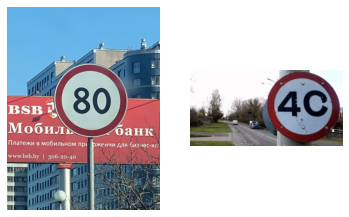

In [4]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow. It is assumed that all images have at least one sign, and as such, in the data augmentation section, no cropping transformations will be made.

In [5]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_max_area_class_from_annotion(image_filename)

    def get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define simple transforms that normalize each image for each model

In [6]:
def transform_normalize(input_size, mean, std):
    train_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform


Define batch size and num workers

In [7]:
batch_size = 64
num_workers = 0 # How many processes are used to load the data

Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [8]:
def get_dataloaders(input_size, mean, std, transform_f):
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

Define device

In [9]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily. This class trains a model for a given number of epochs, keeps track of the accuracy and loss of the model accross all epochs, and can save or load the model anytime

In [10]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs # Epochs that each training session will have
        self.loss = loss
        self.optimizer = optimizer
        self.device = device
        self.scheduler = None
        self.accuracies = {}

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = self.activation_out(probs)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

        metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics
    
    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        with open(acc_path, 'w') as f:
            f.write(json.dumps(self.accuracies))

    def load_model(self, file_name):
        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()
        
        with open(acc_path, 'r') as f:
            self.accuracies = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        train_loss, train_metrics = train_data
        val_loss, val_metrics = val_data
        self.accuracies[stage] = {
            "train": {
                "loss": train_loss,
                "metrics": train_metrics
            },
            "val": {
                "loss": val_loss,
                "metrics": val_metrics
            },         
        }

    def reset_accuracy(self):
        self.accuracies = {}
    
    def get_best_score(self):
        def get_score(node):
            return node["val"]["metrics"]["accuracy"]
        
        m_acc, m_stage = 0, ""
        for stg in self.accuracies:
            acc = get_score(self.accuracies[stg])
            if acc > m_acc:
                m_acc = acc
                m_stage = stg
        return m_acc, m_stage

    def set_scheduler(self, scheduler, gamma):
        if scheduler != None:
            self.scheduler = scheduler(self.optimizer, gamma)

    def train(self, train_dataloader, validation_dataloader, stage, progress_bar=False):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (exº fine tunning)
        accuracies = []
        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}", end=" - ")

            # Train
            train_loss, train_metrics = self._epoch_iter(train_dataloader, True, progress_bar)
            train_acc = train_metrics["accuracy"]

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}", end=" - ")

            # Test
            val_loss, val_metrics = self._epoch_iter(validation_dataloader, False, progress_bar)
            val_acc = val_metrics["accuracy"]
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")
            
            # If scheduler exists, update lr
            if self.scheduler != None:
                self.scheduler.step()

            # save training history for plotting purposes
            self.append_history(
                f'{stage}_{t}',
                (train_loss, train_metrics),
                (val_loss, val_metrics)
            )

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1
            
        print("Finished")

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        if hasattr(self.model, 'classifier'):
            last_item_index = len(self.model.classifier)-1
            layer = self.model.classifier.__getitem__(last_item_index)
            layer.weight.requires_grad = True
        elif hasattr(self.model, 'fc'):
            self.model.fc.weight.requires_grad = True

    def visualize_model(self, val_dataloader, classes, num_images=6): # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
        was_training = self.model.training
        self.model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    class_names = list(classes.keys())
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    cv.imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        self.model.train(mode=was_training)
                        return
            self.model.train(mode=was_training)

The function bellow will plot the accuracy and loss of a training session

In [11]:
def plotTrainingHistory(accuracies, session):
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    classes_pre = {c:[] for c in classes}
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])
        for c in classes_pre:
            pre = epoch_acc["val"]["metrics"][str(classes[c])]["precision"]
            classes_pre[c].append(pre)

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(20)
    plt.subplot(4, 1, 2)
    plt.title('Per Class Precision')
    for c in classes:  
        plt.plot(classes_pre[c], label=c)
    plt.legend(loc='best')
    plt.show()

And the function bellow will be used to try and load an existing model so that we don't have to retrain it when running the notebook

In [12]:
def load_model(trainer): # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        trainer.load_model("best_model")
        return True


### ResNet-50
ResNet-50 expects an input size of 224, and expects images to be normalized according to the following mean and std values. We use these values to retrieve the dataloaders. In this initial setup, we will only normalize each image. Data augmentation will be tinkered with later.

In [13]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

Charactarize training and validation sets

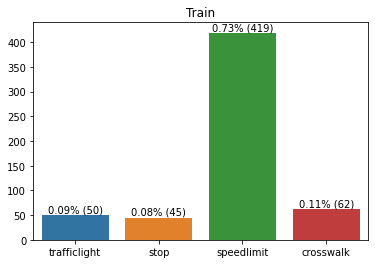

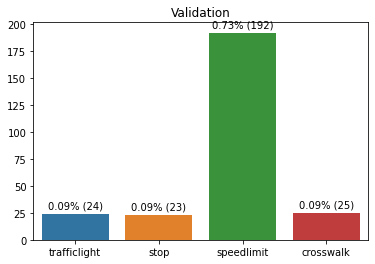

In [16]:
def describe_dataloader(dataloader, title):
    train_vals = np.array([])
    for batch, (X, y) in enumerate(dataloader):
        train_vals = np.append(train_vals, y.numpy())

    freqs = {c:np.count_nonzero(train_vals == classes[c]) for c in classes}
    keys = list(freqs.keys())
    vals = [int(freqs[k]) for k in keys]
    s = sum(vals)
    labels = [val / s for val in vals]
    labels = [f"{labels[i]:.2f}% ({vals[i]})" for i in range(len(labels))]
    ax = sns.barplot(x=keys, y=vals)
    patches = ax.patches
    ax.set_title(title)
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+5
        ax.annotate(labels[i], (x, y), ha='center')
    plt.show()

describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

As can be seen, the speedlimit class is clearly the most predominant sign with the highest area across all images. This predominance is present on both validation and train sets. 

#### Transfer Learning

We define a pretrained ResNet-50 as our baseline, with 10 epochs, cross entropy loss, and SGD optimizer. We will compare all models with this one.

In [14]:
resnet_model_trained = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2),
}

#summary(resnet["model"], (3, input_size, input_size))

First we do **transfer learning** - train only the last layer while freezing all others.

In [15]:
resnet_trainer = ModelTrainer(resnet_trained, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistory(resnet_trainer.accuracies, "frozen")

Start training...

Epoch 0 - Train loss: 0.985 	 Train acc: 0.658 - Val loss: 0.809 	 Val acc: 0.727

Epoch 1 - 

KeyboardInterrupt: 

We can see that the model can distinguish most of the speedlimit signs, while not knowing how to deal with crosswalks or trafficlights. During the last epochs the model seems to have learned how to identify stop signs.

Perform **fine tunning** - unfreeze all layers and train with a small learning rate a small number of epochs. We expect better fine tuned results after this.

Start training...

Epoch 10 - Train loss: 0.441 	 Train acc: 0.882 - Val loss: 0.445 	 Val acc: 0.864

Epoch 11 - Train loss: 0.442 	 Train acc: 0.872 - Val loss: 0.446 	 Val acc: 0.864

Epoch 12 - Train loss: 0.450 	 Train acc: 0.861 - Val loss: 0.445 	 Val acc: 0.864
Finished


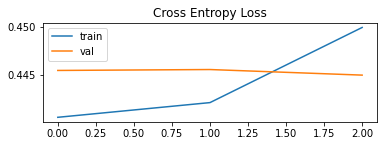

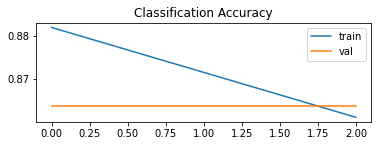

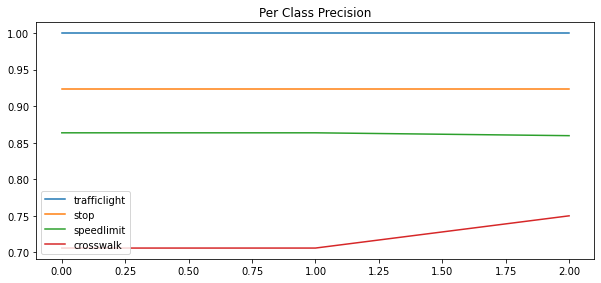

In [19]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistory(resnet_trainer.accuracies, "fine_tuning")

As we can see, our best result was 0.754, which we consider satisfactory as the learning rate is fixed and we are applying few data augmentation. In addition, fine tunning has given the model the capability to distinguish crosswalk signs, but traffic lights are still not being detected.

Now let's bundle this into a function that does the transfer learning process

In [20]:
def transfer_learn(name, model,
                   opt_freeze, lr_freeze, ep_freeze,
                   opt_fine_tune, lr_fine_tune, ep_fine_tune,
                   load,
                   scheduler_freeze=None, scheduler_fine_tune=None,
                   scheduler_gamma_freeze=None, scheduler_gamma_fine_tune=None):

    # change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
    if hasattr(model, 'classifier'): # VGG 
        last_item_index = len(model.classifier)-1
        old_fc = model.classifier.__getitem__(last_item_index)
        new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
        model.classifier.__setitem__(last_item_index , new_fc)
    elif hasattr(model, 'fc'): # Resnet
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.to(device)

    model_d = {
        "model": model,
        "name": name,
        #"num_epochs": 50,
        "num_epochs": ep_freeze,
        "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
        "optimizer": opt_freeze(model.parameters(), lr=lr_freeze)
    }

    trainer = ModelTrainer(model_d, device)
    trainer.set_scheduler(scheduler_freeze, scheduler_gamma_freeze)
    # Freeze all layers expect last
    trainer.freeze_layers()
    trainer.unfreeze_fc()

    # Training can be skipped by loading the best model until now
    if load:
        need_train = (load_model(trainer) == False)
    if not load or need_train:
        need_train = True
        trainer.train(train_dataloader, val_dataloader, "frozen")

    # Unfreeze all layers - fine tuning
    trainer.optimizer = opt_fine_tune(model.parameters(), lr=lr_fine_tune)
    trainer.set_scheduler(scheduler_fine_tune, scheduler_gamma_fine_tune)
    trainer.num_epochs = ep_fine_tune
    trainer.unfreeze_layers()

    if need_train: # Train if previous cell has trained too
        trainer.train(train_dataloader, val_dataloader, "fine_tuning")

    plotTrainingHistory(trainer.accuracies, "frozen")
    plotTrainingHistory(trainer.accuracies, "fine_tuning")
    return trainer


##### **Optimizer Tuning**

Now we will experiment with different optimizers and compare results

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 3.086 	 Train acc: 0.562 - Val loss: 1.327 	 Val acc: 0.777

Epoch 1 - Train loss: 1.773 	 Train acc: 0.734 - Val loss: 0.660 	 Val acc: 0.723

Epoch 2 - Train loss: 0.920 	 Train acc: 0.766 - Val loss: 0.389 	 Val acc: 0.852

Epoch 3 - Train loss: 0.376 	 Train acc: 0.872 - Val loss: 0.372 	 Val acc: 0.879

Epoch 4 - Train loss: 0.257 	 Train acc: 0.918 - Val loss: 0.332 	 Val acc: 0.875

Epoch 5 - Train loss: 0.196 	 Train acc: 0.932 - Val loss: 0.277 	 Val acc: 0.886

Epoch 6 - Train loss: 0.172 	 Train acc: 0.948 - Val loss: 0.296 	 Val acc: 0.902

Epoch 7 - Train loss: 0.153 	 Train acc: 0.946 - Val loss: 0.332 	 Val acc: 0.894

Epoch 8 - Train loss: 0.129 	 Train acc: 0.960 - Val loss: 0.262 	 Val acc: 0.917

Epoch 9 - Train loss: 0.104 	 Train acc: 0.970 - Val loss: 0.257 	 Val acc: 0.917
Finished
Start training...

Epoch 10 - Train loss: 0.117 	 Train acc: 0.984 - Val loss: 0.255 	 Val acc: 0.924


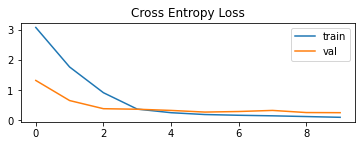

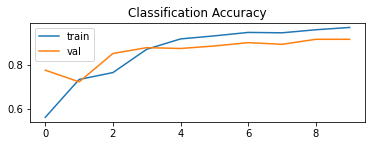

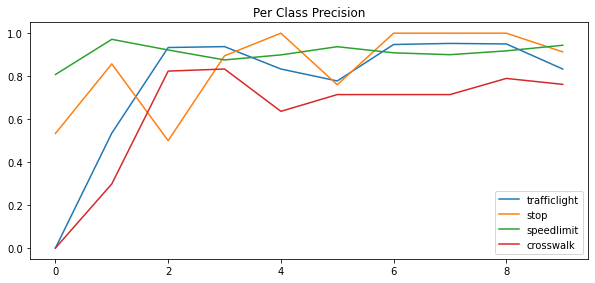

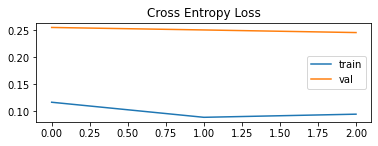

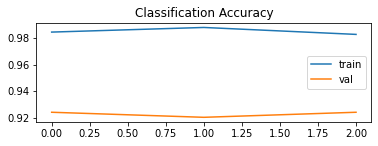

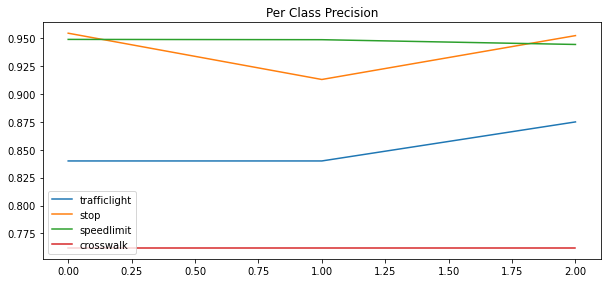

(0.9242424242424242, 'fine_tuning_10')

In [21]:
# Adam optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adam_best_score = trainer.get_best_score()
adam_best_score

In [22]:
# Adamax optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adamax",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adamax,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adamax,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adamax_best_score = trainer.get_best_score()
adamax_best_score

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 2.896 	 Train acc: 0.568 - Val loss: 1.407 	 Val acc: 0.273

Epoch 1 - Train loss: 1.093 	 Train acc: 0.724 - Val loss: 0.622 	 Val acc: 0.784

Epoch 2 - 

KeyboardInterrupt: 

In [ ]:
# RMSprop optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_rmsprop",
    model=resnet_model_trained,
    opt_freeze=torch.optim.RMSprop,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.RMSprop,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
rmsprop_best_score = trainer.get_best_score()
rmsprop_best_score

In [29]:
adam_best_score, adamax_best_score, rmsprop_best_score

((0.8787878787878788, 'frozen_8'),
 (0.8484848484848485, 'fine_tuning_11'),
 (0.7651515151515151, 'frozen_6'))

As can be seen, the optimizer that provided the best results was adam. It increased accuracy from 75% to 85%.

#### **Learning Rate Scheduler**

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.839 	 Train acc: 0.543


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.951 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.942 	 Train acc: 0.569


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 2.249 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.804 	 Train acc: 0.773


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Val loss: 2.043 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.917 	 Train acc: 0.783


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.121 	 Val acc: 0.549


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.751 	 Train acc: 0.809


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.155 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.622 	 Train acc: 0.818


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.564 	 Val acc: 0.795


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.554 	 Train acc: 0.812


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val loss: 0.558 	 Val acc: 0.807


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.530 	 Train acc: 0.819


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 0.494 	 Val acc: 0.830


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.550 	 Train acc: 0.821


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.471 	 Val acc: 0.845


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.487 	 Train acc: 0.851


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.449 	 Val acc: 0.837


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.498 	 Train acc: 0.833


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.425 	 Val acc: 0.860


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.490 	 Train acc: 0.849


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.405 	 Val acc: 0.871


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.517 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.409 	 Val acc: 0.871
Finished


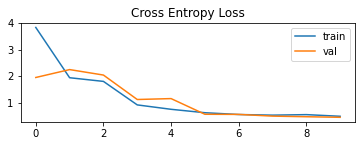

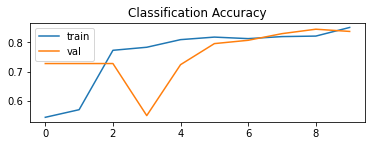

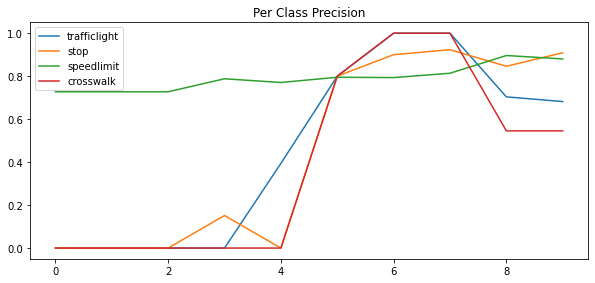

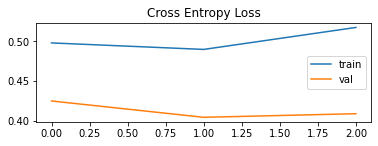

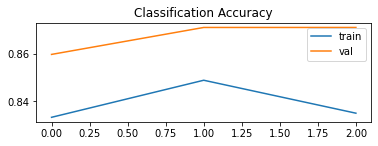

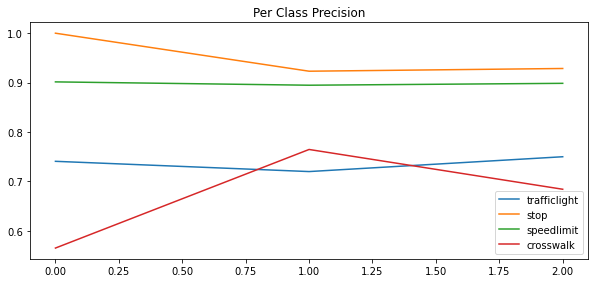

(0.8712121212121212, 'fine_tuning_11')

In [30]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_expLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
expLR_best_score = trainer.get_best_score()
expLR_best_score

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.737 	 Train acc: 0.505


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 2.123 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.854 	 Train acc: 0.686


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.423 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.161 	 Train acc: 0.648


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.922 	 Val acc: 0.299


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.934 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.086 	 Val acc: 0.542


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.726 	 Train acc: 0.797


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.118 	 Val acc: 0.576


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.596 	 Train acc: 0.804


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.636 	 Val acc: 0.814


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.545 	 Train acc: 0.816


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.494 	 Val acc: 0.833


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.518 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.513 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.503 	 Train acc: 0.828


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.502 	 Val acc: 0.841


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.501 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.414 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.460 	 Train acc: 0.839


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.408 	 Val acc: 0.856


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.495 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.389 	 Val acc: 0.852


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.451 	 Train acc: 0.847


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 0.384 	 Val acc: 0.864
Finished


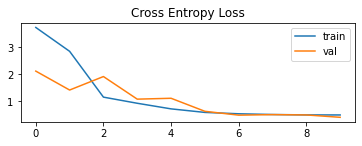

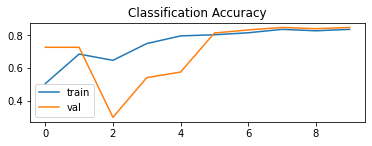

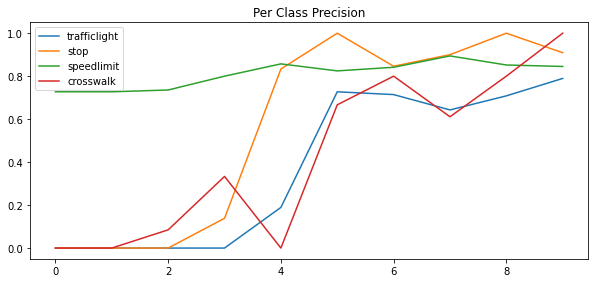

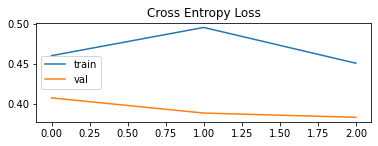

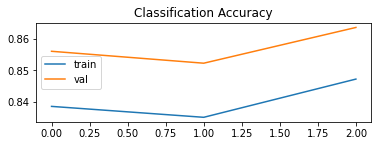

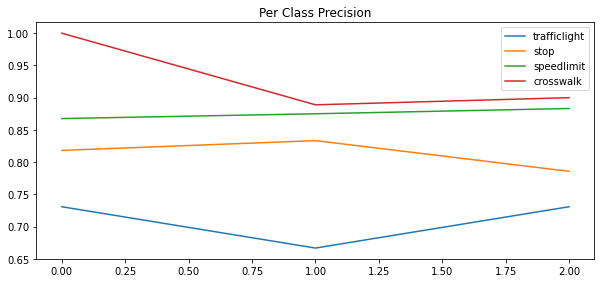

(0.8636363636363636, 'fine_tuning_12')

In [31]:
# StepLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_stepLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
stepLR_best_score = trainer.get_best_score()
stepLR_best_score

In [32]:
rmsprop_best_score

(0.7651515151515151, 'frozen_6')

ExpLR had the best results, with an increase of 3% in accuracy

#### Train from scratch

Now let's train the network from **scratch**, with the same hyperparams except learning rate, which was increased to get to the minima faster.

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.495 	 Train acc: 0.651


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 716060.906 	 Val acc: 0.091


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.273 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 140413.288 	 Val acc: 0.083


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.884 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 1004.070 	 Val acc: 0.689


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.920 	 Train acc: 0.759


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 9.044 	 Val acc: 0.735


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.847 	 Train acc: 0.748


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 0.709 	 Val acc: 0.761


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.771 	 Train acc: 0.740


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.623 	 Val acc: 0.746


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.747 	 Train acc: 0.762


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 1.584 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.796 	 Train acc: 0.752


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Val loss: 0.801 	 Val acc: 0.758


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.841 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Val loss: 0.658 	 Val acc: 0.761


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.701 	 Train acc: 0.748


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Val loss: 0.669 	 Val acc: 0.754
Finished


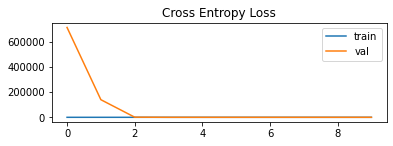

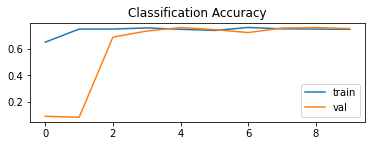

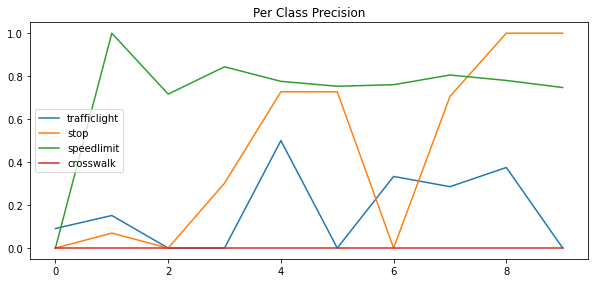

(0.7613636363636364, 'scratch_4')

In [128]:
resnet_model_scratch = models.resnet50(pretrained=False)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_scratch.fc.in_features
resnet_model_scratch.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_scratch.to(device)

resnet_scratch = {
    "model": resnet_model_scratch,
    "name": 'resnet50_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

resnet_trainer = ModelTrainer(resnet_scratch, device)
# Unfreeze all layers
resnet_trainer.unfreeze_layers()
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)

if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(resnet_trainer.accuracies, "scratch")
resnet_trainer.get_best_score()

The group was surprised with the results being so high (76%), we were expecting a lower accuracy.

### VGG-16

VGG-16 Expects the same input size and normalization as ResNet-50, so it will be the same. In this brief section we will only train this network two times: with transfer learning and from scratch. This process is the same to what was done with resnet.

In [60]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)
vgg_model_pretrained = models.vgg16(pretrained=True)

trainer = transfer_learn(
    name="resnet50_pretrained_adam_stepLR",
    model=vgg_model_pretrained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)
vgg_best_score = trainer.get_best_score()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Start training...

Epoch 0 - Train loss: 2.285 	 Train acc: 0.668 - Val loss: 0.867 	 Val acc: 0.814

Epoch 1 - 

KeyboardInterrupt: 

Training from scratch

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.384 	 Train acc: 0.252


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.387 	 Train acc: 0.257


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.250


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.220


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.229


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.238


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.207


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.220


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.224


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.384 	 Train acc: 0.233


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125
Finished


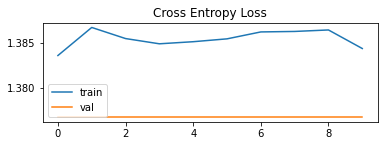

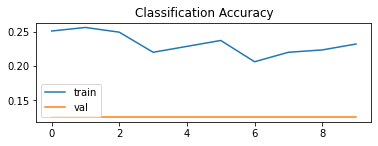

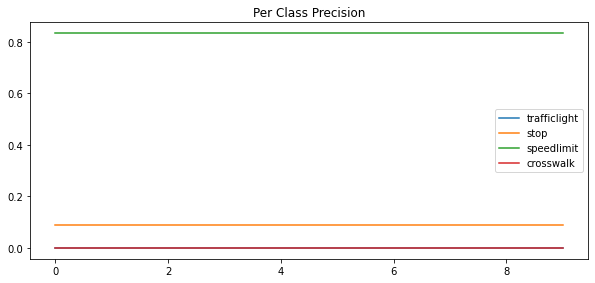

(0.125, 'scratch_0')

In [132]:
vgg_model_scratch = models.vgg16(pretrained=False)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
last_item_index = len(vgg_model_scratch.classifier)-1
old_fc = vgg_model_scratch.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
vgg_model_scratch.classifier.__setitem__(last_item_index , new_fc)
vgg_model_scratch.to(device)

vgg_scratch = {
    "model": vgg_model_scratch,
    "name": 'vgg_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

vgg_trainer = ModelTrainer(vgg_scratch, device)
# Unfreeze all layers
vgg_trainer.unfreeze_layers()
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(vgg_trainer) == False)
if not load or need_train:
    vgg_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(vgg_trainer.accuracies, "scratch")
vgg_trainer.get_best_score()

As we can see the results were extremly poor. We don't know why there is a huge descrepancy between this value and the accuracy achieved by Resnet from scratch (75%)

## Data Augmentation

The experimented data augmentation methods can be seen bellow. Different combintations were tried, and these were chosen due to them giving better results. 

In [16]:
def transform_data(input_size, mean, std):
    train_transform = A.Compose([
        A.RandomScale(scale_limit=0.5, interpolation=1, p=0.2),
        A.Rotate(limit=40, interpolation=1, p=0.2),
        A.ElasticTransform(p=0.1),
        A.HorizontalFlip(p=0.2),
        A.Downscale(scale_min=0.25, scale_max=0.25, p=0.1),
        A.RandomBrightnessContrast(p=0.2),
        A.OneOf([ # Noise
            A.GaussNoise(p=0.3),
            A.ImageCompression(p=0.2, quality_lower=20, quality_upper=70),
            A.Sharpen(p=0.3)
        ], p=0.2),
        A.OneOf([ # Distortion
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([ # Blurring
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([ # Color
            A.ToGray(p=0.2),
            A.ToSepia(p=0.2),
            A.RGBShift(r_shift_limit=40, g_shift_limit=60, b_shift_limit=40, p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        ], p=0.2),
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform

input_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_data)

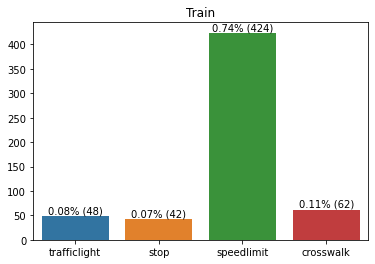

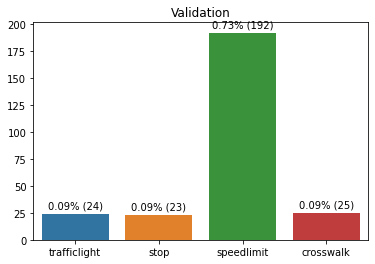

In [42]:
describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

Let's add these transformations with the best model, ResNet50 with ADAM and ExpLR with transfer learning.

In [19]:
expLR_best_score

NameError: name 'expLR_best_score' is not defined

In [80]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_expLR_dataloader",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)
data_aug_best_score = trainer.get_best_score()
data_aug_best_score

NameError: name 'transfer_learn' is not defined

We can conclude that this greatly improves results, from 85% to 92%

## Custom Architecture

Bellow we define our custom architecture

In [17]:
class CustomCNN(nn.Module):
    def __init__(self, input_size):
        super(CustomCNN, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3
        flatten_size = (((((input_size - 2 - 2) // 2) - 2 - 2) // 2) ** 2 * self.nb_filters)

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.BatchNorm2d(self.nb_filters),
            nn.Dropout(0.25),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.BatchNorm2d(self.nb_filters),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = CustomCNN(input_size)
model.to(device)
summary(model, (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
            Conv2d-3         [-1, 32, 220, 220]           9,248
              ReLU-4         [-1, 32, 220, 220]               0
         MaxPool2d-5         [-1, 32, 110, 110]               0
       BatchNorm2d-6         [-1, 32, 110, 110]              64
           Dropout-7         [-1, 32, 110, 110]               0
            Conv2d-8         [-1, 32, 108, 108]           9,248
              ReLU-9         [-1, 32, 108, 108]               0
           Conv2d-10         [-1, 32, 106, 106]           9,248
             ReLU-11         [-1, 32, 106, 106]               0
        MaxPool2d-12           [-1, 32, 53, 53]               0
      BatchNorm2d-13           [-1, 32, 53, 53]              64
          Dropout-14           [-1, 32,

For training, we will be using the optimzer, LR scheduler and data augmentations that have given us the best results.

In [19]:
input_size = 224 # Keeo the same input size
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # And mean & std just for consistency
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_data)

Start training...

Epoch 0 - Train loss: 1.480 	 Train acc: 0.207 - Val loss: 1.447 	 Val acc: 0.182

Epoch 1 - Train loss: 1.498 	 Train acc: 0.203 - Val loss: 1.448 	 Val acc: 0.189

Epoch 2 - Train loss: 1.512 	 Train acc: 0.156 - Val loss: 1.448 	 Val acc: 0.189

Epoch 3 - Train loss: 1.495 	 Train acc: 0.196 - Val loss: 1.448 	 Val acc: 0.186

Epoch 4 - Train loss: 1.497 	 Train acc: 0.172 - Val loss: 1.448 	 Val acc: 0.182

Epoch 5 - Train loss: 1.471 	 Train acc: 0.193 - Val loss: 1.448 	 Val acc: 0.174

Epoch 6 - Train loss: 1.494 	 Train acc: 0.198 - Val loss: 1.449 	 Val acc: 0.182

Epoch 7 - Train loss: 1.468 	 Train acc: 0.201 - Val loss: 1.449 	 Val acc: 0.178

Epoch 8 - Train loss: 1.486 	 Train acc: 0.172 - Val loss: 1.449 	 Val acc: 0.186

Epoch 9 - Train loss: 1.503 	 Train acc: 0.186 - Val loss: 1.448 	 Val acc: 0.189
Finished


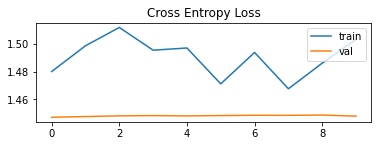

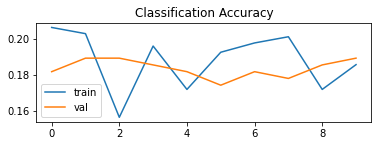

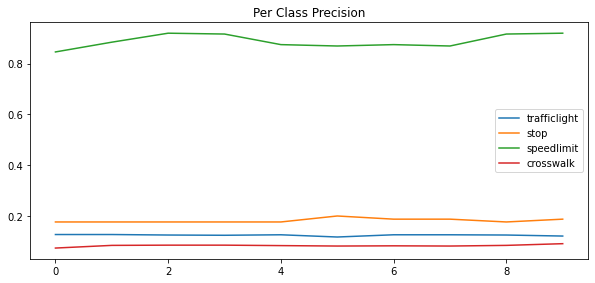

In [20]:
model.to(device)

custom_trained = {
    "model": model,
    "name": 'customCNN',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-2),
}

custom_trainer = ModelTrainer(custom_trained, device)
custom_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Unfreeze all layers expect last
custom_trainer.unfreeze_layers()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(custom_trainer) == False)
if not load or need_train:
    need_train = True
    custom_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(custom_trainer.accuracies, "scratch")

As we can see, the results of our custom architecture aren't that satisfactory, the model struggles to achieve a better accuracy value than 20%. We believe that this problem is complex for the number of layers that we used. More layers were experimented with, but the high number of parameters were making the training process too time consuming. 

## Multilabeling
First we need to redefine the dataset to take into consideration multiple labels. Instead of returning the biggest area class, we will be returing what types of signs the image has.

In [13]:
classes # Remember our target classes

{'trafficlight': 0, 'stop': 1, 'speedlimit': 2, 'crosswalk': 3}

In [21]:
class TrafficSignDatasetMultiLabel(TrafficSignDataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_classes_from_annotation(image_filename)

    def get_classes_from_annotation(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            c = torch.zeros(num_classes)
            objects = root.findall("object")
            for object in objects:
                c_name = object.find("name").text
                if c_name in classes and c[classes[c_name]] == 0:
                    c[classes[c_name]] = 1

        return c

input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

We will redefine de ModelTrainer class to take into account multiple labels. This implies using a sigmoid in the predictions to map the output vals to a workable range. This will be used to convert the problem into a multiple binary classification problem. For this, we define a threshold probability that is applied for each class to choose if the image prediction contains that class. 

In [22]:
MODELS_DIR = "models"

class ModelTrainerMultiLabel(ModelTrainer):
    def __init__(self, args, device):
        super().__init__(args, device) 

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                pred = F.sigmoid(pred)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                preds.append(pred.cpu().detach())
                labels.append(y.cpu().detach())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        preds = preds.int()
        labels = labels.int()
        acc = accuracy(preds, labels, num_classes=4, average="macro", multiclass=False)

        metrics = {
            'accuracy': acc.item()
        }

        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics

We will be using the data transformations from the previous section. Mean and std are the same as before because they don't need to vary between Resnet, VGG and our custom architecture

In [23]:
def get_dataloaders_multilabel(input_size, mean, std, transform_f): # Same as above but we use the multilabel dataset
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDatasetMultiLabel(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDatasetMultiLabel(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = get_dataloaders_multilabel(input_size, mean, std, transform_data)

In [24]:
def plotTrainingHistoryMultilabel(accuracies, session): # Only plots accuracy
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

Now we can train the tree networks so far in multilabeling. We will be using the optimizer and LR schedulers that have given best results until now.

Resnet with fine tuning

Start training...

Epoch 0 - 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 1.124 	 Train acc: 0.371 - Val loss: 0.652 	 Val acc: 0.419

Epoch 1 - Train loss: 0.458 	 Train acc: 0.410 - Val loss: 0.516 	 Val acc: 0.533

Epoch 2 - Train loss: 0.364 	 Train acc: 0.475 - Val loss: 0.256 	 Val acc: 0.692

Epoch 3 - Train loss: 0.264 	 Train acc: 0.568 - Val loss: 0.215 	 Val acc: 0.633

Epoch 4 - Train loss: 0.238 	 Train acc: 0.611 - Val loss: 0.211 	 Val acc: 0.583

Epoch 5 - Train loss: 0.211 	 Train acc: 0.635 - Val loss: 0.199 	 Val acc: 0.639

Epoch 6 - Train loss: 0.211 	 Train acc: 0.610 - Val loss: 0.206 	 Val acc: 0.664

Epoch 7 - Train loss: 0.192 	 Train acc: 0.672 - Val loss: 0.210 	 Val acc: 0.593

Epoch 8 - Train loss: 0.200 	 Train acc: 0.640 - Val loss: 0.184 	 Val acc: 0.694

Epoch 9 - Train loss: 0.191 	 Train acc: 0.645 - Val loss: 0.178 	 Val acc: 0.714
Finished
Start training...

Epoch 10 - Train loss: 0.195 	 Train acc: 0.688 - Val loss: 0.175 	 Val acc: 0.736

Epoch 11 - Train loss: 0.188 	 Train acc: 0.727 - Val loss: 0.173 	 V

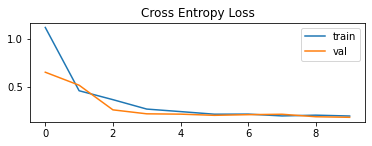

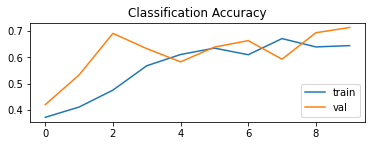

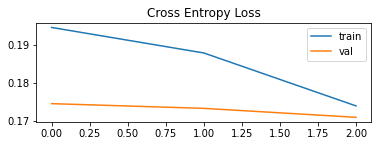

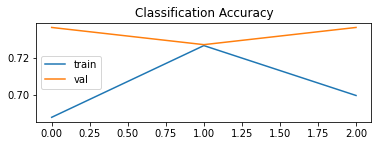

(0.7364405989646912, 'fine_tuning_10')

In [24]:
resnet_model_trained = models.resnet50(pretrained=True)
# number of neurons in the last layer to the number of classes is the same
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-2)
}

resnet_trainer = ModelTrainerMultiLabel(resnet_trained, device)
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Freeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

# Unfreeze all layers - fine tuning
resnet_trainer.optimizer = torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
resnet_trainer.num_epochs = 3
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistoryMultilabel(resnet_trainer.accuracies, "frozen")
plotTrainingHistoryMultilabel(resnet_trainer.accuracies, "fine_tuning")
resnet_trainer.get_best_score()

Vgg with fine tuning

Start training...

Epoch 0 - Train loss: 1.029 	 Train acc: 0.320 - Val loss: 0.353 	 Val acc: 0.634

Epoch 1 - Train loss: 0.431 	 Train acc: 0.642 - Val loss: 0.338 	 Val acc: 0.507

Epoch 2 - Train loss: 0.313 	 Train acc: 0.608 - Val loss: 0.271 	 Val acc: 0.806

Epoch 3 - Train loss: 0.270 	 Train acc: 0.682 - Val loss: 0.245 	 Val acc: 0.768

Epoch 4 - Train loss: 0.305 	 Train acc: 0.627 - Val loss: 0.228 	 Val acc: 0.854

Epoch 5 - Train loss: 0.243 	 Train acc: 0.724 - Val loss: 0.197 	 Val acc: 0.746

Epoch 6 - Train loss: 0.205 	 Train acc: 0.733 - Val loss: 0.200 	 Val acc: 0.830

Epoch 7 - Train loss: 0.218 	 Train acc: 0.707 - Val loss: 0.197 	 Val acc: 0.729

Epoch 8 - Train loss: 0.230 	 Train acc: 0.698 - Val loss: 0.184 	 Val acc: 0.821

Epoch 9 - Train loss: 0.201 	 Train acc: 0.725 - Val loss: 0.179 	 Val acc: 0.781
Finished
Start training...

Epoch 10 - Train loss: 0.202 	 Train acc: 0.713 - Val loss: 0.176 	 Val acc: 0.783

Epoch 11 - Train loss: 0.229 	 Train acc

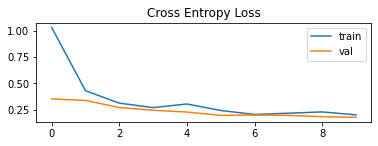

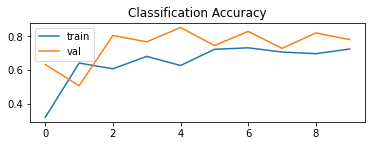

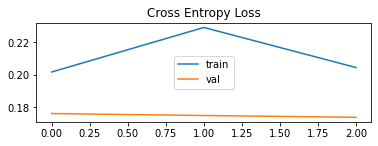

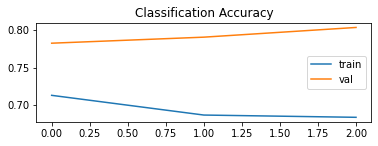

(0.8535604476928711, 'frozen_4')

In [ ]:
vgg_model_trained= models.vgg16(pretrained=True)
# number of neurons in the last layer to the number of classes is the same
last_item_index = len(vgg_model_trained.classifier)-1
old_fc = vgg_model_trained.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
vgg_model_trained.classifier.__setitem__(last_item_index, new_fc)
vgg_model_trained.to(device)

vgg_trained = {
    "model": vgg_model_trained,
    "name": 'vgg_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(vgg_model_trained.parameters(), lr=1e-2)
}

vgg_trainer = ModelTrainerMultiLabel(vgg_trained, device)
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
# Freeze all layers expect last
vgg_trainer.freeze_layers()
vgg_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(vgg_trainer) == False)
if not load or need_train:
    need_train = True
    vgg_trainer.train(train_dataloader, val_dataloader, "frozen")

# Unfreeze all layers - fine tuning
vgg_trainer.optimizer = torch.optim.Adam(vgg_model_trained.parameters(), lr=1e-6)
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
vgg_trainer.num_epochs = 3
vgg_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    vgg_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistoryMultilabel(vgg_trainer.accuracies, "frozen")
plotTrainingHistoryMultilabel(vgg_trainer.accuracies, "fine_tuning")
vgg_trainer.get_best_score()

Custom architecture

Loaded custom_multilabel obtained in epoch scratch_3


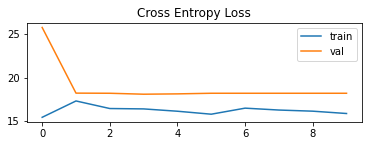

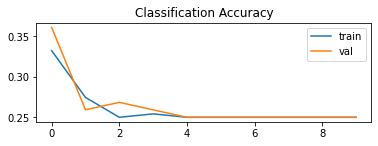

(0.3611111044883728, 'scratch_0')

In [27]:
custom_model= CustomCNN(input_size)
custom_model.to(device)

custom_model_d = {
    "model": custom_model,
    "name": 'custom_multilabel',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(custom_model.parameters(), lr=1e-2)
}

custom_trainer = ModelTrainerMultiLabel(custom_model_d, device)
custom_trainer.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, 0.9)
custom_trainer.unfreeze_layers()

# Training can be skipped by loading the best model until now
load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(custom_trainer) == False)
if not load or need_train:
    need_train = True
    custom_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistoryMultilabel(custom_trainer.accuracies, "scratch")
custom_trainer.get_best_score()

Similar to the multiclass stage, the custom architecture seems to also struggle in multilabeling.